# AHRS

This Notebook showcases the most important classes and functions included in the Python package `ahrs`.

Here we will explore the basic use of:

- Class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html)
- Class [Quaternion](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternion.html)
- Class [QuaternionArray](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternionArray.html)
- Some [Attitude estimation algorithms](https://ahrs.readthedocs.io/en/latest/filters.html)
- The [World Magnetic Model](https://ahrs.readthedocs.io/en/latest/wmm.html)
- The [World Geodetic System](https://ahrs.readthedocs.io/en/latest/wgs84.html)
- [Metrics functions](https://ahrs.readthedocs.io/en/latest/metrics.html) for orientation representations.
- And diverse tools included in `ahrs`.

### Helping Packages

Plotting and data-handling tools are imported from the script `tools.py` located in the current directory.

- `plot` shows time-series data in vertically stacked plots.
- `plot3` shows a 3D scene, where particles, frames, and items exist and interact in the same space.

Packages `matplotlib` and `ipympl` are required to build interactive visualizations in the Notebook. Make sure you have those installed.

These tools simplify the visualization of orientations in 3d, or time-series data, but are **NOT** included in the `ahrs` package.

Once you have `ahrs` installed (which also installs `numpy`) and you have the forementioned libraries, we can start by setting our notebook up.

In [1]:
# Use widgets
%matplotlib widget

# Import NumPy
import numpy as np

# Seed random generator
GENERATOR = np.random.default_rng(42)

# Import plotting tools
from tools import plot
from tools import plot3

## AHRS Basics

We can start now. Let's import our favorite package.

In [2]:
import ahrs

## Attitude Representations

The first elements we want to manipulate and use are the representations of any Attitude (that's the "A" in AHRS.)

There are many ways to mathematically represent the attitude:

1. Direction Cosine Matrix.
2. Euler Angles.
3. Axis-Angle.
4. Quaternion.

Let's check the most intuitive first.

### Direction Cosine Matrix

The [Direction Cosine Matrix](https://ahrs.readthedocs.io/en/latest/dcm.html)can be built with the class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html). This represents either:

- the **orientation** of a frame in 3D space with respect to another reference frame in the same space, or
- the **linear operation**, where a point (or points) is (are) rotated according the rotation described in the DCM.

Normally the global frame is represented by the 3x3 Identity matrix.

Global frame:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


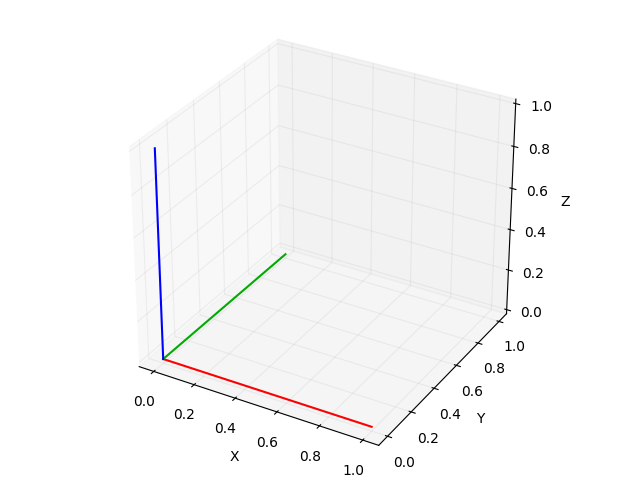

In [3]:
global_frame = ahrs.DCM()    # An empty DCM is initialized as the global frame
print("Global frame:")
print(global_frame.view())
plot3(frames=global_frame)

As you can see, any frame in 3D can be visualized with three orthogonal axes of length one. The X-, Y-, and Z-axis are represented with red, green and blue color, respectively.

Each axis is described in the columns of the DCM:

$$
\begin{bmatrix}
  \color{red}{|} &  \color{green}{|} & \color{blue}{|} \\
  \color{red}{X} &  \color{green}{Y} & \color{blue}{Z} \\
  \color{red}{|} &  \color{green}{|} & \color{blue}{|}
 \end{bmatrix}
$$

To make it easier. Imagine:

- The first column describes the three-dimensional postition of the X-axis tip (red)
- The second column describes the three-dimensional postition of the Y-axis tip (green)
- The third column describes the three-dimensional postition of the Z-axis tip (blue)

Go back up and see that the visualized frame actually describes the columns of the global frame.

$$
\begin{array}{lcr}
X = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} &
Y = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix} &
Z = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
\end{array}
$$

The class `DCM` works in radians. If you want to use degrees, you can transform your values with the helper constant `DEG2RAD`.

Now let's built a matrix describing a rotation of 45° about the Z-axis, and confirm that its elements describe the position of each Axis' tip.

Rotation of 45° about global frame's Z-axis:
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


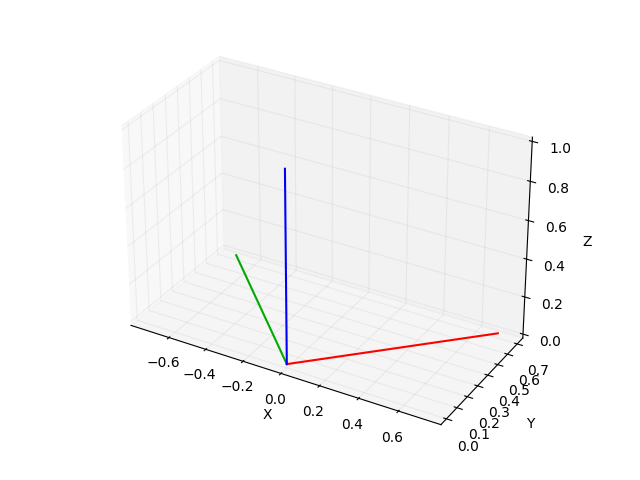

In [4]:
rotated_frame = ahrs.DCM(z=45.0*ahrs.DEG2RAD)    # DCM rotated 45 degrees (see helper constant) about the Z-axis
print("Rotation of 45° about global frame's Z-axis:")
print(rotated_frame.view())
plot3(frames=rotated_frame)

You see the Z-axis (blue) remains unchanged, while the other points rotate around it, as expected.

The class `DCM` is derived from [NumPy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html), and its attributes and methods are kept.

The DCM's characteristics in SO(3) are conveniently added. Operations between DCMs yield DCMs too.

You can also build the DCM, by giving it any valid $3\times 3$ orthogonal matrix in [SO(3)](https://en.wikipedia.org/wiki/3D_rotation_group).

In [5]:
valid_rotation = ahrs.DCM(np.array([[np.sqrt(2)/2, -np.sqrt(2)/2, 0], [np.sqrt(2)/2, np.sqrt(2)/2, 0], [0, 0, 1]]))
valid_rotation.view()

DCM([[ 0.70710678, -0.70710678,  0.        ],
     [ 0.70710678,  0.70710678,  0.        ],
     [ 0.        ,  0.        ,  1.        ]])

It will fail if it is not in SO(3)

In [6]:
invalid_rotation = ahrs.DCM(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))

ValueError: Given attitude is not in SO(3)

### Euler Angles

DCMs can be built in different ways, the most famous one is through Euler Angles.

These angles, first introduced by [Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler) are three angles describing the orientation of an object with respect to a fixed coordinate system.

Three composed (chained) **elemental rotations** are always sufficient to reach any frame in 3D space. In this case, we can build each rotation separately with our class `DCM` by setting it in its constructor.

The chained multiplication of these orientations yields a final composed orientation.

Because the rotation operations are **always with respect to the initial global frame**, it is called an **[Extrinsic rotation](https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_extrinsic_rotations)**.

In [7]:
print("Rotation of 10 degrees about X-axis:")
print(ahrs.DCM(x=10.0*ahrs.DEG2RAD))

print("Rotation of 20 degrees about Y-axis:")
print(ahrs.DCM(y=20.0*ahrs.DEG2RAD))

print("Rotation of 30 degrees about Z-axis:")
print(ahrs.DCM(z=30.0*ahrs.DEG2RAD))

# New rotation matrix from products of rotations about X-, Y-, and Z-axis, respectively.
# Order of matrix multiplication is right to left: x --> y --> z
orientation = ahrs.DCM(z=30.0*ahrs.DEG2RAD) @ ahrs.DCM(y=20.0*ahrs.DEG2RAD) @ ahrs.DCM(x=10.0*ahrs.DEG2RAD)

print(f"Rotation Matrix {type(orientation)}:")
print(orientation)

Rotation of 10 degrees about X-axis:
[[ 1.          0.          0.        ]
 [ 0.          0.98480775 -0.17364818]
 [ 0.          0.17364818  0.98480775]]
Rotation of 20 degrees about Y-axis:
[[ 0.93969262  0.          0.34202014]
 [ 0.          1.          0.        ]
 [-0.34202014  0.          0.93969262]]
Rotation of 30 degrees about Z-axis:
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Rotation Matrix <class 'ahrs.common.dcm.DCM'>:
[[ 0.81379768 -0.44096961  0.37852231]
 [ 0.46984631  0.88256412  0.01802831]
 [-0.34202014  0.16317591  0.92541658]]


This proces can be simplified at creation of the DCM object setting the [Euler angles](https://en.wikipedia.org/wiki/Euler_angles) tuple:

In [8]:
orientation = ahrs.DCM( euler=('zyx', np.array([30.0, 20.0, 10.0])*ahrs.DEG2RAD) )
orientation.view()

DCM([[ 0.81379768, -0.44096961,  0.37852231],
     [ 0.46984631,  0.88256412,  0.01802831],
     [-0.34202014,  0.16317591,  0.92541658]])

As you can see, for the Euler angles we tried to match the mathematical order of multiplication from right to left.

The custom class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html) includes the basic attributes describing the mathematical properties of a DCM.

In [9]:
attribute_list = ['T', 'I', 'inv', 'det', 'determinant', 'fro', 'frobenius', 'adj', 'adjugate', 'log']
for attribute_name in attribute_list:
    print(f"rotation.{attribute_name} =")
    print(orientation.__getattribute__(attribute_name), '\n')

rotation.T =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.I =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.inv =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.det =
1.0000000000000002 

rotation.determinant =
1.0000000000000002 

rotation.fro =
1.7320508075688772 

rotation.frobenius =
1.7320508075688772 

rotation.adj =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.adjugate =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.log =
[[ 0.          0.48647923 -0.38485157]
 [-0.48647923  0.          0.07752532]
 [ 0.38485157 -0.07752532  0.        ]] 



For a full detail of its properties, see its [documentation](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html).

On top of that, it has a plethora of methods that help us to get extra information.

In [10]:
# List all DCM methods and the first descriptive line from each docstring
from tools import describe_methods
describe_methods(orientation)

DCM.all()               Returns True if all elements evaluate to True.
DCM.any()               Returns True if any of the elements of `a` evaluate to True.
DCM.argmax()            Return indices of the maximum values along the given axis.
DCM.argmin()            Return indices of the minimum values along the given axis.
DCM.argpartition()      Returns the indices that would partition this array.
DCM.argsort()           Returns the indices that would sort this array.
DCM.astype()            Copy of the array, cast to a specified type.
DCM.byteswap()          Swap the bytes of the array elements
DCM.choose()            Use an index array to construct a new array from a set of choices.
DCM.clip()              Return an array whose values are limited to ``[min, max]``.
DCM.compress()          Return selected slices of this array along given axis.
DCM.conj()              Complex-conjugate all elements.
DCM.conjugate()         Return the complex conjugate, element-wise.
DCM.copy()           

Have a look at the documentation of the class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html) for more details about the most important methods.

### Axis-Angle

A rotation can also be expressed with a pair parametrizing it. This pair is the axis of rotation as a three-dimensional vector, and its corresponding angle of rotation.

For example, for the rotation above, we simply indicate that we rotate 45° around the Z-axis like this:

In [11]:
rotation = ahrs.DCM(axang=([0, 0, 1], 45*ahrs.DEG2RAD))
rotation.view()

DCM([[ 0.70710678, -0.70710678,  0.        ],
     [ 0.70710678,  0.70710678,  0.        ],
     [ 0.        ,  0.        ,  1.        ]])

Notice the axis **MUST** have a norm equal to 1.

$$
Z = \begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix}
$$

To guarantee it the method [from_axisangle](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.from_axisangle.html) (used by the class DCM) normalizes it immediately.

In [12]:
ahrs.DCM(axang=([0, 0, 2], 45*ahrs.DEG2RAD))

DCM([[ 0.70710678, -0.70710678,  0.        ],
     [ 0.70710678,  0.70710678,  0.        ],
     [ 0.        ,  0.        ,  1.        ]])

### Quaternions

The fourth and most useful representation explored here is the Quaternion.

With `ahrs` you build [unit Quaternions](https://en.wikipedia.org/wiki/Quaternion#Unit_quaternion), a.k.a. [Versors](https://en.wikipedia.org/wiki/Versor), even with an empty call, which returns the so-called `identity quaternion`:

$$
\mathbf{q} = \begin{bmatrix}1 & 0 & 0 & 0\end{bmatrix}
$$

In [13]:
q = ahrs.Quaternion()
q.view()

Quaternion([1., 0., 0., 0.])

As with the DCM, we can initialize our quaternions in different ways:

In [14]:
print("Random quaternion:\n", ahrs.Quaternion(random=True))
print("4-element array:\n", ahrs.Quaternion([1., -2., 3., -4]))
print("3-element array:\n", ahrs.Quaternion([1., -2., 3.]))
print("From DCM:\n", ahrs.Quaternion(dcm=np.array([[np.sqrt(2)/2, -np.sqrt(2)/2, 0], [np.sqrt(2)/2, np.sqrt(2)/2, 0], [0, 0, 1]])))
print("Roll-pitch-yaw angles:\n", ahrs.Quaternion(rpy=np.array([30.0, 20.0, 10.0])*ahrs.DEG2RAD))

Random quaternion:
 (0.5240 +0.8448i +0.1028j -0.0354k)
4-element array:
 (0.1826 -0.3651i +0.5477j -0.7303k)
3-element array:
 (0.0000 +0.2673i -0.5345j +0.8018k)
From DCM:
 (0.9239 +0.0000i +0.0000j +0.3827k)
Roll-pitch-yaw angles:
 (0.9515 +0.2393i +0.1893j +0.0381k)


We can notice some things here:

- Quaternion inputs are ALWAYS normalized.
- When we cast the Quaternion as a [string](https://docs.python.org/3/library/stdtypes.html#text-sequence-type-str) (call it in a print) we get a "prettier" representation based on [Hamilton's initial description](https://en.wikipedia.org/wiki/History_of_quaternions#Hamilton's_discovery) of the basis vectors using $\mathcal{i}$, $\mathcal{j}$, and $\mathcal{k}$ for the vector part.
- When a quaternion is built with 3 items. It creates a pure quaternion, that is a quaternion with a scalar part equal to 0, while the 3 elements are set for the vector part.

Going back to the example above, we can represent the orientation as quaternion giving the values of the roll-pitch-yaw angles:

In [15]:
q = ahrs.Quaternion(rpy=([0, 0, 45*ahrs.DEG2RAD]))
q.view()

Quaternion([0.92387953, 0.        , 0.        , 0.38268343])

This quaternion represents the same Direction Cosine Matrix of a 45° rotation around the Z-axis (yaw angle):

In [16]:
q.to_DCM()

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The class [Quaternion](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternion.html) is also subclassed from [NumPy Arrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), and expands its attributes and methods describing the quaternion:

In [17]:
describe_methods(q)

Quaternion.all()               Returns True if all elements evaluate to True.
Quaternion.any()               Returns True if any of the elements of `a` evaluate to True.
Quaternion.argmax()            Return indices of the maximum values along the given axis.
Quaternion.argmin()            Return indices of the minimum values along the given axis.
Quaternion.argpartition()      Returns the indices that would partition this array.
Quaternion.argsort()           Returns the indices that would sort this array.
Quaternion.astype()            Copy of the array, cast to a specified type.
Quaternion.byteswap()          Swap the bytes of the array elements
Quaternion.choose()            Use an index array to construct a new array from a set of choices.
Quaternion.clip()              Return an array whose values are limited to ``[min, max]``.
Quaternion.compress()          Return selected slices of this array along given axis.
Quaternion.copy()              Return a copy of the array.
Quaternio

For a detailed description of each method and attribute, please check the class' [documentation](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternion.html)

Here are the available attributes:

In [18]:
attribute_list = ['w', 'x', 'y', 'z', 'v', 'conjugate', 'conj', 'inverse', 'inv', 'exponential', 'exp', 'logarithm', 'log']
for attribute_name in attribute_list:
    print(f"{q.__class__.__name__}.{attribute_name} =")
    print(q.__getattribute__(attribute_name), '\n')

Quaternion.w =
0.9238795325112867 

Quaternion.x =
0.0 

Quaternion.y =
0.0 

Quaternion.z =
0.3826834323650898 

Quaternion.v =
[0.         0.         0.38268343] 

Quaternion.conjugate =
[ 0.92387953 -0.         -0.         -0.38268343] 

Quaternion.conj =
[ 0.92387953 -0.         -0.         -0.38268343] 

Quaternion.inverse =
[ 0.92387953 -0.         -0.         -0.38268343] 

Quaternion.inv =
[ 0.92387953 -0.         -0.         -0.38268343] 

Quaternion.exponential =
[2.33683151 0.         0.         0.94063915] 

Quaternion.exp =
[2.33683151 0.         0.         0.94063915] 

Quaternion.logarithm =
[0.         0.         0.         0.39269908] 

Quaternion.log =
[0.         0.         0.         0.39269908] 



We cannot visualize the four-dimensional quaternion, but we can represent it in three-dimensions if we convert it to a DCM. Then, we can visualize it.

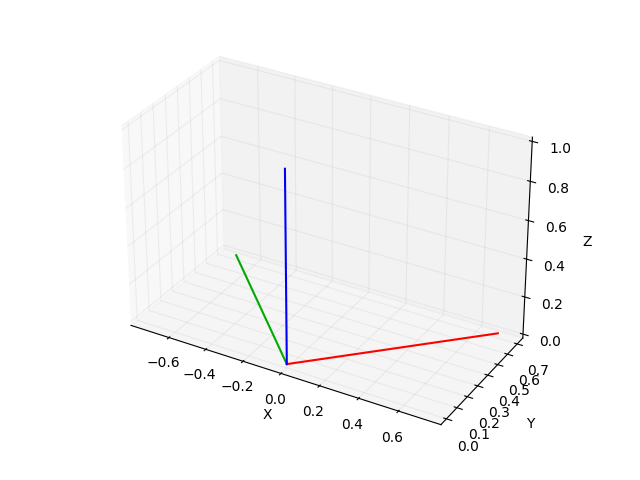

In [19]:
dcm = q.to_DCM()
plot3(frames=dcm)

Quaternions are very versatile and, contrary to modern myths, very easy to use. For example, if we require the opposite. We merely negate the vector part. This "opposite" rotation/orientation is called the [quaternion conjugate](https://en.wikipedia.org/wiki/Quaternion#Conjugation,_the_norm,_and_reciprocal).

Quaternion conjugate:
 [ 0.92387953 -0.         -0.         -0.38268343]


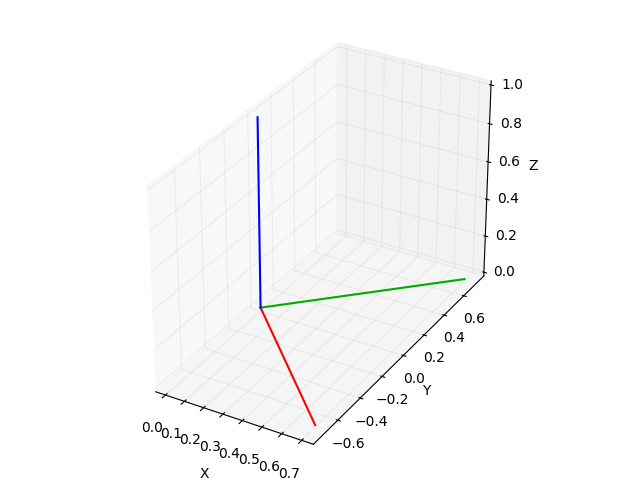

In [20]:
q_c = q.conjugate
print(f"Quaternion conjugate:\n", q_c)
dcm_inv = ahrs.Quaternion(q_c).to_DCM()
plot3(frames=dcm_inv)

The original quaternion described a **counter-clockwise** rotation of 45° about the Z-axis, whereas its conjugate describes a **clockwise** rotation of 45° about the Z-axis.

### QuaternionArray

There is an extra class called [QuaternionArray](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternionArray.html), which, as the name suggests, handles more than one quaternion at once.

This simplifies repetitive operations between quaternions, and even gives computes new properties already.

Let's build an array of quaternions similar to the quaternion above, but different from each other by minor perturbances.

In [21]:
Quaternions = ahrs.QuaternionArray(np.tile([1., 0., 0., np.sqrt(2)-1], (5, 1)) + np.random.randn(5, 4)*0.05)
Quaternions.view()

QuaternionArray([[ 0.93183287, -0.05024691,  0.01409294,  0.35911576],
                 [ 0.90868641, -0.01665855, -0.0163846 ,  0.41682495],
                 [ 0.90768371,  0.00500482,  0.08082771,  0.41176707],
                 [ 0.93390891, -0.01990315,  0.00845252,  0.35685651],
                 [ 0.89776317,  0.01604867,  0.01667136,  0.43987021]])

In this case, we can visualize the array of Quaternions using a simple time-series plot.

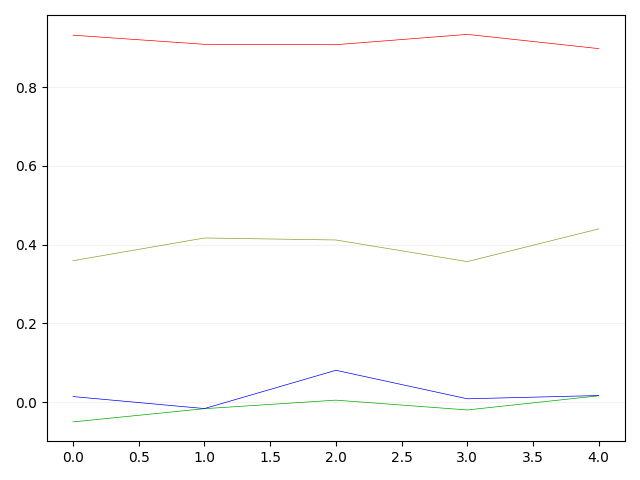

In [22]:
plot(Quaternions)

We can see that every element is plotted per line, where the red line corresponds to the first column (scalar values, or $q_w$), green to the second column ($q_x$), blue to the third column ($q_y$), and gold to the fourth column ($q_z$)

In [23]:
describe_methods(Quaternions)

QuaternionArray.all()               Returns True if all elements evaluate to True.
QuaternionArray.angular_velocities()Compute the angular velocity between N Quaternions.
QuaternionArray.any()               Returns True if any of the elements of `a` evaluate to True.
QuaternionArray.argmax()            Return indices of the maximum values along the given axis.
QuaternionArray.argmin()            Return indices of the minimum values along the given axis.
QuaternionArray.argpartition()      Returns the indices that would partition this array.
QuaternionArray.argsort()           Returns the indices that would sort this array.
QuaternionArray.astype()            Copy of the array, cast to a specified type.
QuaternionArray.average()           Average quaternion using Markley's method :cite:`markley2007`.
QuaternionArray.byteswap()          Swap the bytes of the array elements
QuaternionArray.choose()            Use an index array to construct a new array from a set of choices.
QuaternionArr

Class `QuaternionArray` has almost all the same methods as the class `Quaternion`, but with some extra useful ones:

In [24]:
# Mean Quaternion
Quaternions.average()

# WARNING: method `mean()` inherited from numpy.array
# will compute the numerical mean over all array values,
# which is NOT the Mean Quaternion

array([-0.91729279,  0.01317295, -0.02074901, -0.39745425])

In [25]:
# Angular Velocity around X-, Y-, and Z-axis from orientations as Quaternions (given sampling rate in seconds)
Quaternions.angular_velocities(0.1)  # Assumes sampling rate of 0.1 s (10 Hz)

array([[ 0.36754881, -0.86071183,  1.22059071],
       [ 1.20212312,  1.58747003, -0.05827215],
       [-0.96206463, -1.15664081, -1.24582246],
       [ 0.70175164, -0.13001414,  1.81787076]])

In [26]:
# Interpolate missing Quaternion using SLERP
Quaternions[2] = np.nan
print("Array missing 3rd quaternion:\n", Quaternions)

Quaternions.slerp_nan(inplace=True)
print("Array with SLERP:\n", Quaternions)

Array missing 3rd quaternion:
 [[ 0.93183287 -0.05024691  0.01409294  0.35911576]
 [ 0.90868641 -0.01665855 -0.0163846   0.41682495]
 [        nan         nan         nan         nan]
 [ 0.93390891 -0.01990315  0.00845252  0.35685651]
 [ 0.89776317  0.01604867  0.01667136  0.43987021]]
Array with SLERP:
 [[ 0.93183287 -0.05024691  0.01409294  0.35911576]
 [ 0.90868641 -0.01665855 -0.0163846   0.41682495]
 [ 0.92185784 -0.01829197 -0.00396845  0.38707594]
 [ 0.93390891 -0.01990315  0.00845252  0.35685651]
 [ 0.89776317  0.01604867  0.01667136  0.43987021]]


The quaternions $\begin{bmatrix}q_w & q_x & q_y & q_z\end{bmatrix}$ and $\begin{bmatrix}-q_w & -q_x & -q_y & -q_z\end{bmatrix}$ represent the same orientation, but some people prefer to have them more consistent.

The method [remove_jumps](https://ahrs.readthedocs.io/en/latest/quaternion/quaternionarray.remove_jumps.html) "flips" the opposite quaternions to make them more "pleasant" for the user.

In [27]:
# Negate the 4th Quaternion (still same orientation)
Quaternions[3] *= -1
print("Array with negated quaternion (4th):\n", Quaternions)

# "Flip" quaternion back
Quaternions.remove_jumps()
print("Array with 4th quaternion 'flipped back':\n", Quaternions)

Array with negated quaternion (4th):
 [[ 0.93183287 -0.05024691  0.01409294  0.35911576]
 [ 0.90868641 -0.01665855 -0.0163846   0.41682495]
 [ 0.92185784 -0.01829197 -0.00396845  0.38707594]
 [-0.93390891  0.01990315 -0.00845252 -0.35685651]
 [ 0.89776317  0.01604867  0.01667136  0.43987021]]
Array with 4th quaternion 'flipped back':
 [[ 0.93183287 -0.05024691  0.01409294  0.35911576]
 [ 0.90868641 -0.01665855 -0.0163846   0.41682495]
 [ 0.92185784 -0.01829197 -0.00396845  0.38707594]
 [ 0.93390891 -0.01990315  0.00845252  0.35685651]
 [ 0.89776317  0.01604867  0.01667136  0.43987021]]
